In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1634
            Open  High   Low  Close  Volume Ticker
Time                                              
2017-06-02  3410  3440  3290   3320    2580    VIB
2017-06-05  3320  3410  3290   3290   39900    VIB
2017-06-06  3310  3320  3290   3320   53340    VIB
2017-06-07  3420  3420  3310   3340   69855    VIB
2017-06-08  3310  3310  3290   3310   50310    VIB
2017-06-09  3290  3310  3290   3290   43100    VIB


<Axes: xlabel='Time'>

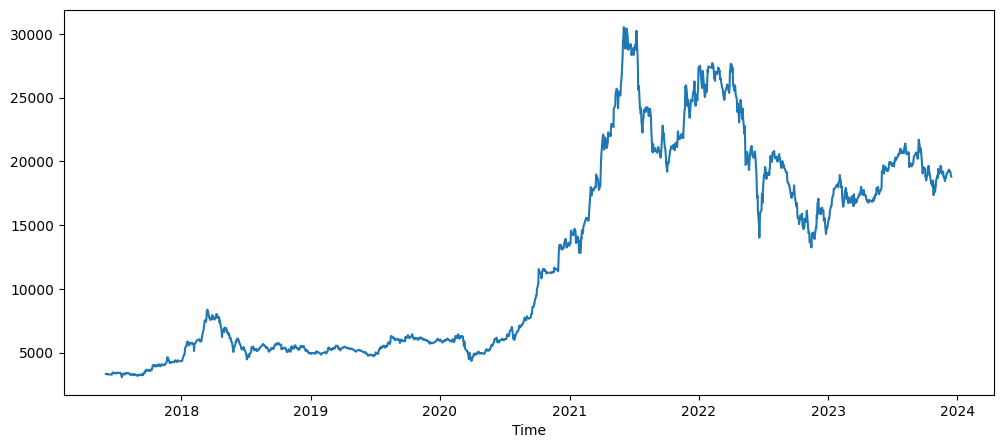

In [3]:
# Import data
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VIB['Close']))
print(pd.DataFrame(VIB.head(6)))
train_dates = VIB.index
plt.figure(figsize=(12, 5))
VIB["Close"].plot()

In [4]:
VIB = VIB.reset_index(drop = True)
df = VIB['Close']
df

0        3320
1        3290
2        3320
3        3340
4        3310
        ...  
1629    19200
1630    19200
1631    19050
1632    18900
1633    18800
Name: Close, Length: 1634, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7,IMF8
0,4.136591,-0.340466,20.009337,-43.235137,21.544463,111.103854,277.452864,2929.328495
1,-20.532078,-7.728711,25.369307,-46.893051,22.324488,110.957096,277.646268,2928.856681
2,-1.497472,2.984534,28.148191,-49.963753,23.307004,110.563874,278.050454,2928.407168
3,12.192678,12.051475,26.938509,-52.255629,24.506764,109.919463,278.666809,2927.979930
4,-2.181541,3.070344,20.571077,-53.484309,25.933438,109.019468,279.496584,2927.574941
...,...,...,...,...,...,...,...,...
1629,-51.373412,144.756697,309.505781,-260.334230,-785.485094,3028.088185,-4413.769115,21228.611188
1630,41.930756,98.284498,269.037682,-277.390908,-767.878402,3024.310857,-4409.955146,21221.660662
1631,8.750369,42.567550,208.019068,-285.797312,-752.471190,3020.230460,-4405.946198,21214.647254
1632,-25.994595,-6.897925,136.635415,-286.057059,-739.361728,3015.847683,-4401.742741,21207.570951


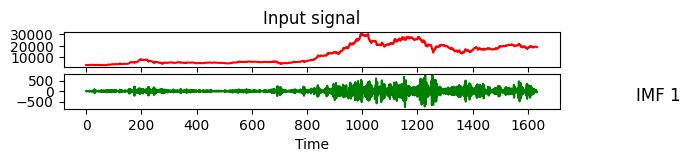

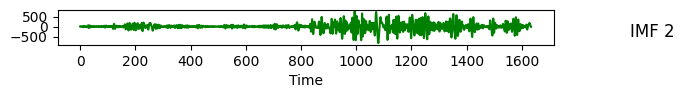

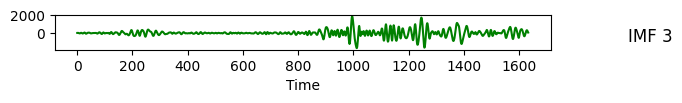

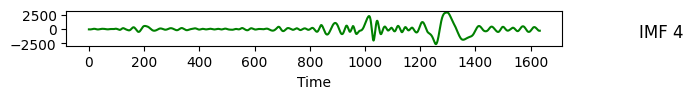

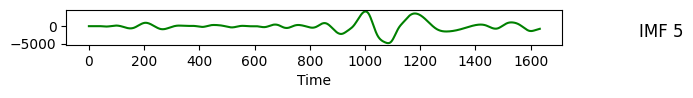

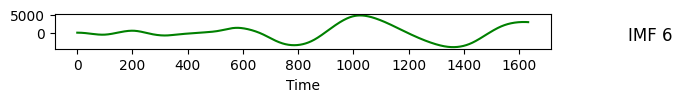

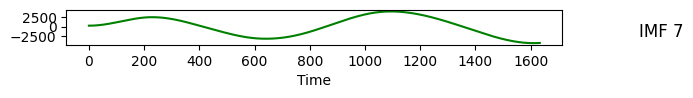

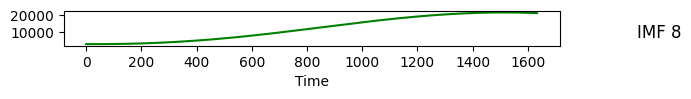

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1634, 1)
Residue: (1634, 1)


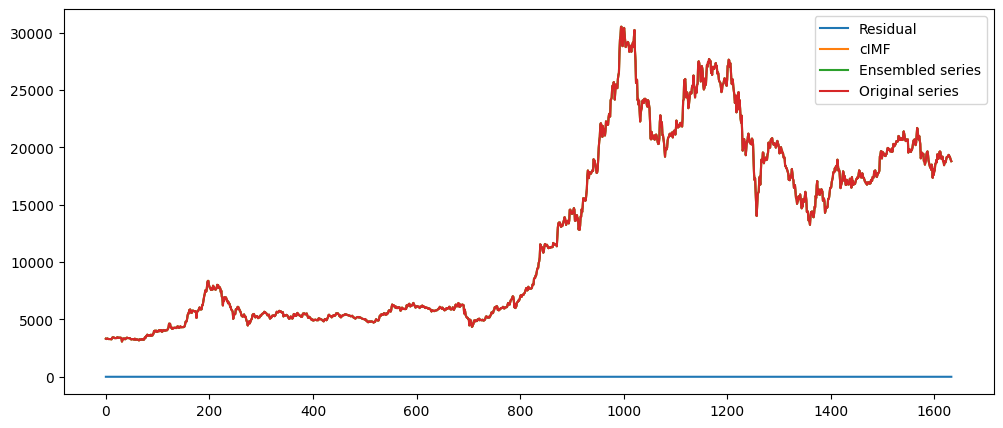

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing

In [13]:
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [14]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[ 3320.],
       [ 3290.],
       [ 3320.],
       ...,
       [19050.],
       [18900.],
       [18800.]])

In [15]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1634, 1)
Train:  (980, 1)
Test:  (654, 1)


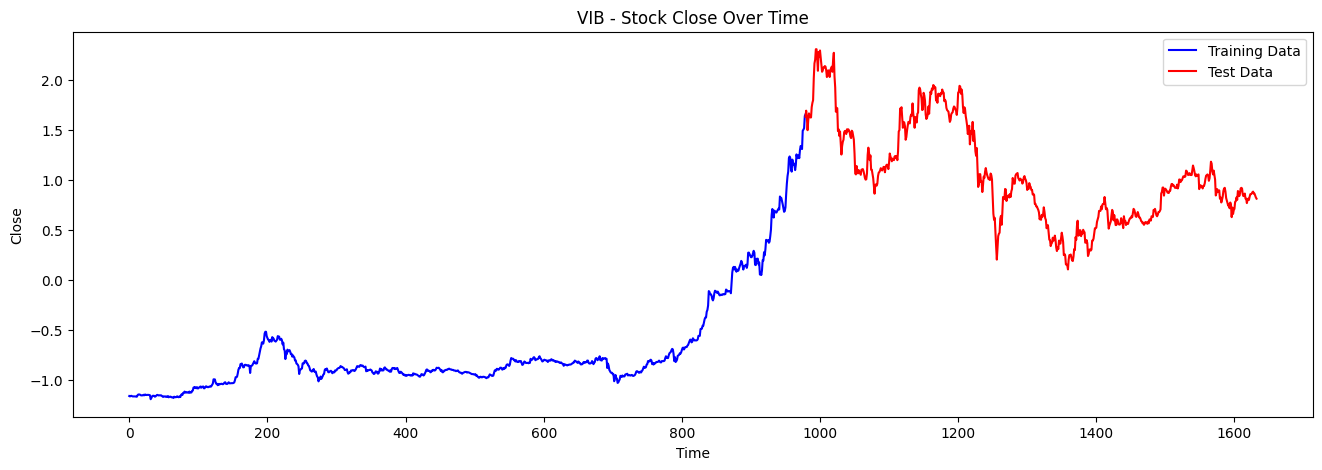

In [19]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.6*IMFscale.shape[0])
test_size = int(0.4*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(16, 5))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [17]:
trainX = []
trainY = []

n_past = 14
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (966, 14, 1)
Y train:  (966, 1)


In [18]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (640, 14, 1)
Y test:  (640, 1)


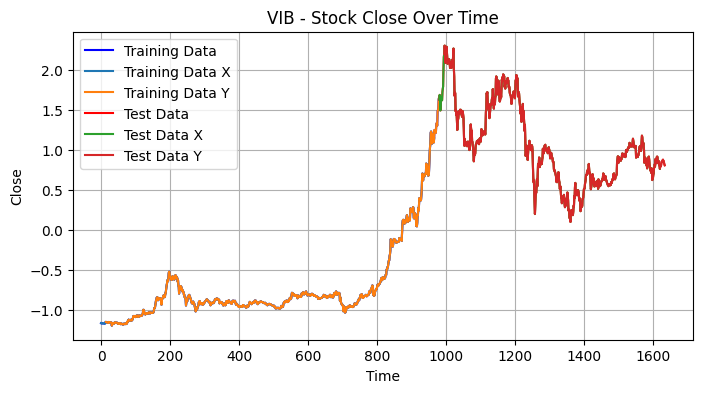

In [20]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-14), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(14,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-13), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+14, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/100
218/218 [==============================] - 4s 8ms/step - loss: 26.7574 - val_loss: 75.7180
Epoch 2/100
218/218 [==============================] - 2s 7ms/step - loss: 18.8105 - val_loss: 48.8897
Epoch 3/100
218/218 [==============================] - 2s 8ms/step - loss: 17.2565 - val_loss: 55.9126
Epoch 4/100
218/218 [==============================] - 1s 7ms/step - loss: 16.5512 - val_loss: 61.8724
Epoch 5/100
218/218 [==============================] - 2s 7ms/step - loss: 15.5455 - val_loss: 143.0979
Epoch 6/100
218/218 [==============================] - 1s 7ms/step - loss: 15.0636 - val_loss: 3884.3804
Epoch 7/100
218/218 [==============================] - 2s 7ms/step - loss: 14.9441 - val_loss: 732.2928
Epoch 8/100
218/218 [==============================] - 2s 7ms/step - loss: 15.0129 - val_loss: 397.2701
Epoch 9/100
218/218 [==============================] - 1s 7ms/step - loss: 14.5160 - val_loss: 1668.8140
Epoch 10/100
218/218 [==============================] - 2s 9ms/ste

In [23]:
### 2. Use model to predict test set
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)


20/20 [==============================] - 0s 3ms/step
[25457.205  25263.139  26544.102  25545.074  24822.064  24065.61
 27235.785  24570.25   26659.959  24739.96   24865.287  24265.469
 24926.277  24987.115  24836.338  25073.625  24842.457  24495.654
 23969.928  25170.127  24519.91   24245.27   24208.01   25202.775
 24623.129  25075.29   24211.438  26198.879  25831.834  22875.86
 23509.527  21071.547  22856.846  22289.752  20144.27   21335.186
 20446.432  21206.137  19928.139  19244.273  20360.482  20477.16
 20530.174  21187.969  20986.205  20831.988  20698.357  21228.104
 20796.82   21139.457  20881.633  20806.316  20439.97   20466.95
 21243.3    20815.756  20510.572  20291.543  19175.762  17923.838
 18263.463  19024.318  18443.31   18379.812  18700.002  18508.332
 18421.77   18299.588  18748.89   18673.656  18695.16   18496.797
 18295.914  18055.756  17984.572  18055.914  18528.5    19994.736
 20207.252  19513.555  19018.582  19601.07   18279.658  18598.744
 18271.15   18020.19   1750

In [24]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

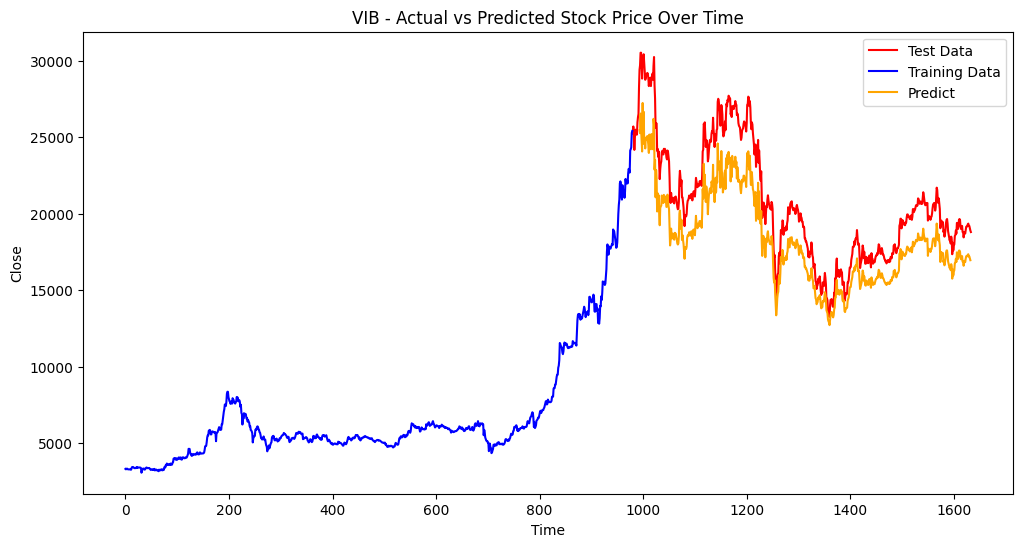

In [25]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+13, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [26]:
### 3. Predict 60 days
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test 14 ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[-14:])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 216ms/step
(655, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 17ms/step
(656, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(657, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(658, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(659, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(660, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(661, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 17ms/step
(662, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 15ms/step
(663, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(664, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(665, 1)
(14, 1)
(1, 14, 1)
1/1 [==============================] - 0s 16ms/step
(666, 1)
(14, 1)
(1, 14, 1)
1/1 [===============

In [27]:
print(y_forecast)

[[16884.9   ]
 [15354.688 ]
 [14281.155 ]
 [13498.44  ]
 [12912.096 ]
 [12470.115 ]
 [12133.964 ]
 [11887.102 ]
 [11708.576 ]
 [11577.955 ]
 [11480.935 ]
 [11408.186 ]
 [11352.915 ]
 [11310.754 ]
 [11279.545 ]
 [11255.495 ]
 [11236.487 ]
 [11221.423 ]
 [11209.858 ]
 [11200.1045]
 [11191.222 ]
 [11182.97  ]
 [11175.74  ]
 [11169.552 ]
 [11164.26  ]
 [11159.77  ]
 [11155.93  ]
 [11152.641 ]
 [11149.827 ]
 [11147.419 ]
 [11145.357 ]
 [11143.593 ]
 [11142.08  ]
 [11140.783 ]
 [11139.672 ]
 [11138.721 ]
 [11137.907 ]
 [11137.21  ]
 [11136.612 ]
 [11136.102 ]
 [11135.664 ]
 [11135.288 ]
 [11134.968 ]
 [11134.692 ]
 [11134.457 ]
 [11134.255 ]
 [11134.083 ]
 [11133.935 ]
 [11133.808 ]
 [11133.699 ]
 [11133.606 ]
 [11133.526 ]
 [11133.458 ]
 [11133.401 ]
 [11133.351 ]
 [11133.309 ]
 [11133.271 ]
 [11133.239 ]
 [11133.213 ]
 [11133.19  ]]


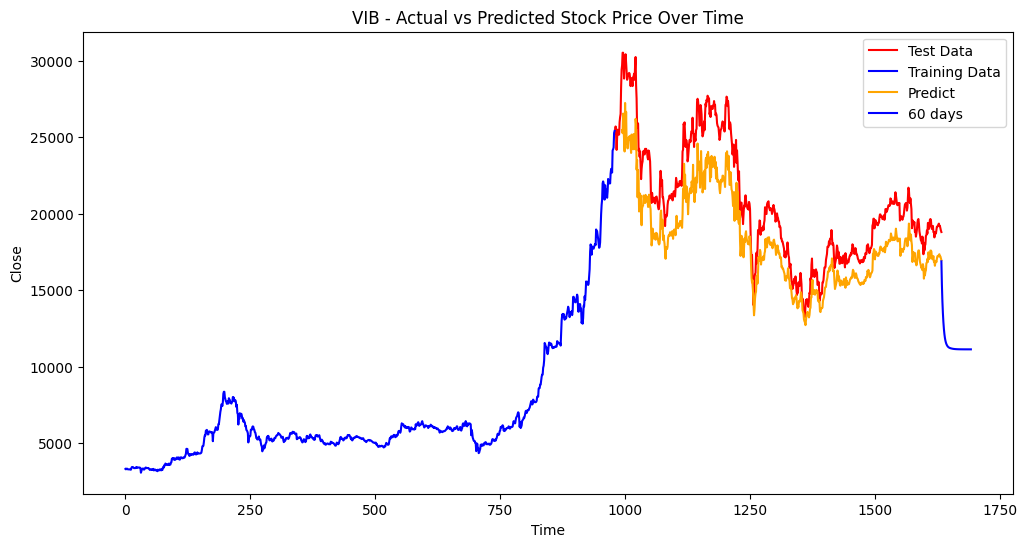

In [28]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size+14, train_size+test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [29]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

In [30]:
print("RSME: ", RSME(y_pred_future, test_back[14:]))
print("MAE: ", MAE(y_pred_future, test_back[14:]))
print("MAPE: ", MAPE(y_pred_future, test_back[14:]))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

RSME:  5392.195682607937
MAE:  4258.887213997841
MAPE:  19.722410924559274
MSLR:  0.07186368787847786
